In [1]:
import tensorflow as tf
import numpy as np
import os
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt


En primera instancia se comprueba que el directorio sobre el que se está trabajando es el adecuado (dado que se usan direcciones relativas)

In [3]:
!dir ..

 El volumen de la unidad C es Windows
 El n�mero de serie del volumen es: 20BA-E688

 Directorio de c:\Users\ruben\Desktop\code_tfm

21/12/2024  18:26    <DIR>          .
20/12/2024  17:18    <DIR>          ..
30/11/2024  01:40    <DIR>          assets
21/12/2024  18:26    <DIR>          clip
30/11/2024  12:02             2.698 config.yml
21/12/2024  11:32    <DIR>          data
30/11/2024  12:27    <DIR>          datasets
30/11/2024  01:41    <DIR>          docs
21/12/2024  11:19    <DIR>          models
30/11/2024  02:00            19.521 poetry.lock
30/11/2024  02:00               315 pyproject.toml
30/11/2024  02:02                 5 README.md
21/12/2024  13:36    <DIR>          src
14/12/2024  13:02    <DIR>          tests
               4 archivos         22.539 bytes
              10 dirs  841.990.991.872 bytes libres


Se definen constantes de paths usadas a lo largo del código

In [4]:

# Paths to COCO dataset
instances_val = r"..\datasets\coco"

COCO_PATH = instances_val
TRAIN_IMAGES_PATH = os.path.join(COCO_PATH, 'images', 'val2017')
ANNOTATIONS_PATH = os.path.join(COCO_PATH, 'annotations', 'instances_val2017.json')



loading annotations into memory...
Done (t=1.38s)
creating index...
index created!
..\datasets\coco\images\val2017\000000532481.jpg


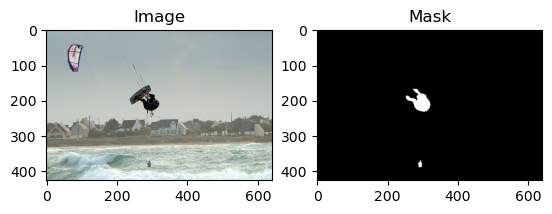

In [5]:


# Load COCO annotations
coco = COCO(ANNOTATIONS_PATH)

# Get category and image IDs
category_ids = coco.getCatIds(catNms=['person'])  # Replace with the desired category
image_ids = coco.getImgIds(catIds=category_ids)

def load_image_and_mask(image_id):
    # Load image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(TRAIN_IMAGES_PATH, img_info['file_name'])
    image = cv2.imread(img_path)
    print(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load segmentation mask
    annotation_ids = coco.getAnnIds(imgIds=image_id, catIds=category_ids, iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in annotations:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

# Example: Display an image and its mask
image, mask = load_image_and_mask(image_ids[0])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


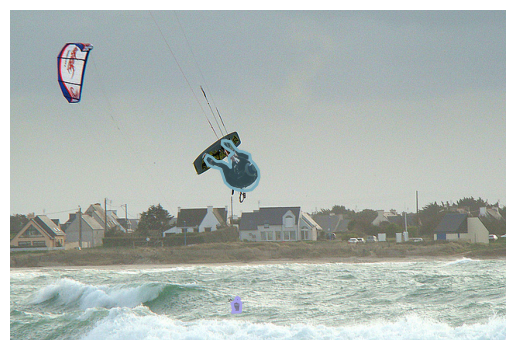

In [6]:
import skimage.io as io


# Get category IDs for "person"
cat_ids = coco.getCatIds(catNms=['person'])

# Get image IDs containing "person"
img_ids = coco.getImgIds(catIds=cat_ids)

# Load an image
img_info = coco.loadImgs(img_ids[0])[0]
image = io.imread(img_info['coco_url'])

# Get annotations for the image
ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids)
annotations = coco.loadAnns(ann_ids)

# Visualize
plt.imshow(image)
coco.showAnns(annotations)
plt.axis('off')
plt.show()


In [7]:
# Given image ID
image_id = coco.getImgIds(catIds=cat_ids)[0]
# Get annotation IDs for the image
ann_ids = coco.getAnnIds(imgIds=[image_id])

# Load annotations
annotations = coco.loadAnns(ann_ids)

# Extract category IDs from annotations
category_ids = set(ann['category_id'] for ann in annotations)

# Load category names using the category IDs
categories = coco.loadCats(category_ids)
category_names = [cat['name'] for cat in categories]

print(f"Instances in image {image_id}: {category_names}")

Instances in image 532481: ['person', 'surfboard', 'car', 'kite']


In [8]:
annotations

[{'segmentation': [[253.85,
    187.23,
    250.82,
    193.01,
    255.22,
    199.6,
    260.99,
    202.35,
    270.89,
    204.55,
    273.64,
    211.15,
    277.21,
    222.15,
    284.09,
    228.47,
    293.71,
    232.04,
    303.06,
    233.14,
    311.03,
    231.77,
    317.9,
    224.9,
    320.93,
    215.55,
    320.1,
    206.48,
    315.43,
    199.05,
    310.2,
    193.56,
    308.83,
    186.13,
    299.48,
    182.28,
    294.81,
    182.01,
    288.49,
    175.96,
    284.09,
    169.36,
    273.64,
    168.26,
    273.09,
    172.94,
    277.49,
    177.34,
    283.81,
    181.46,
    287.94,
    184.48,
    283.26,
    188.06,
    281.61,
    190.53,
    283.54,
    196.58,
    284.36,
    202.9,
    279.96,
    198.5,
    272.54,
    194.93,
    266.77,
    195.21,
    265.12,
    194.38,
    259.89,
    189.43,
    254.12,
    186.96]],
  'area': 2188.0864999999994,
  'iscrowd': 0,
  'image_id': 532481,
  'bbox': [250.82, 168.26, 70.11, 64.88],
  'category_id'

In [9]:
IMG_HEIGHT, IMG_WIDTH = 128, 128

def preprocess(image, mask):
    # Resize
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    # Normalize
    image = image / 255.0
    mask = mask / 255.0
    mask = mask[..., tf.newaxis]  # Add channel dimension

    return image, mask

# Create a TensorFlow dataset
def data_generator(image_ids):
    for image_id in image_ids:
        image, mask = load_image_and_mask(image_id)
        yield preprocess(image, mask)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(image_ids),
    output_signature=(
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 1), dtype=tf.float32)
    )
).batch(16)


In [10]:
def unet_model(output_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output
    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(c5)

    return tf.keras.Model(inputs, outputs)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Función de optimización:

In [ ]:
import tensorflow as tf

def dice_coefficient_multiclass(y_true, y_pred, num_classes, smooth=1e-7):
    dice = 0
    for c in range(num_classes):
        y_true_c = tf.cast(y_true == c, tf.float32)
        y_pred_c = tf.cast(tf.argmax(y_pred, axis=-1) == c, tf.float32)
        
        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        dice_c = (2. * intersection + smooth) / (tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) + smooth)
        dice += dice_c
        
    return dice / num_classes

# Ejemplo de uso
num_classes = 3
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=[lambda y_true, y_pred: dice_coefficient_multiclass(y_true, y_pred, num_classes)])


In [11]:
model.fit(train_dataset, epochs=10)


Epoch 1/10
..\datasets\coco\images\val2017\000000532481.jpg
..\datasets\coco\images\val2017\000000458755.jpg
..\datasets\coco\images\val2017\000000385029.jpg
..\datasets\coco\images\val2017\000000311303.jpg
..\datasets\coco\images\val2017\000000393226.jpg
..\datasets\coco\images\val2017\000000532493.jpg
..\datasets\coco\images\val2017\000000008211.jpg
..\datasets\coco\images\val2017\000000327701.jpg
..\datasets\coco\images\val2017\000000188439.jpg
..\datasets\coco\images\val2017\000000434204.jpg
..\datasets\coco\images\val2017\000000401446.jpg
..\datasets\coco\images\val2017\000000213033.jpg
..\datasets\coco\images\val2017\000000466986.jpg
..\datasets\coco\images\val2017\000000213035.jpg
..\datasets\coco\images\val2017\000000319534.jpg
..\datasets\coco\images\val2017\000000516143.jpg
..\datasets\coco\images\val2017\000000032817.jpg
..\datasets\coco\images\val2017\000000532530.jpg
..\datasets\coco\images\val2017\000000188465.jpg
..\datasets\coco\images\val2017\000000434230.jpg
..\datase

c:\Users\ruben\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


..\datasets\coco\images\val2017\000000532493.jpg
..\datasets\coco\images\val2017\000000008211.jpg
..\datasets\coco\images\val2017\000000327701.jpg
..\datasets\coco\images\val2017\000000188439.jpg
..\datasets\coco\images\val2017\000000434204.jpg
..\datasets\coco\images\val2017\000000401446.jpg
..\datasets\coco\images\val2017\000000213033.jpg
..\datasets\coco\images\val2017\000000466986.jpg
..\datasets\coco\images\val2017\000000213035.jpg
..\datasets\coco\images\val2017\000000319534.jpg
..\datasets\coco\images\val2017\000000516143.jpg
..\datasets\coco\images\val2017\000000032817.jpg
..\datasets\coco\images\val2017\000000532530.jpg
..\datasets\coco\images\val2017\000000188465.jpg
..\datasets\coco\images\val2017\000000434230.jpg
..\datasets\coco\images\val2017\000000475191.jpg
..\datasets\coco\images\val2017\000000254016.jpg
..\datasets\coco\images\val2017\000000131138.jpg
..\datasets\coco\images\val2017\000000016451.jpg
..\datasets\coco\images\val2017\000000081988.jpg
..\datasets\coco\ima

KeyboardInterrupt: 

..\datasets\coco\images\val2017\000000458755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


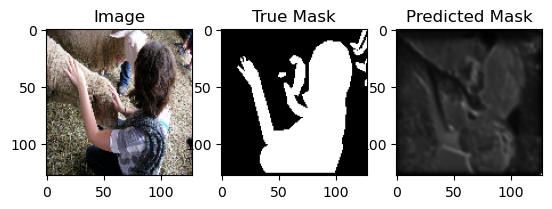

In [12]:
# Predict
image, mask = preprocess(*load_image_and_mask(image_ids[1]))
prediction = model.predict(tf.expand_dims(image, axis=0))[0]

# Display results
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Image")
plt.subplot(1, 3, 2)
plt.imshow(mask[..., 0], cmap='gray')
plt.title("True Mask")
plt.subplot(1, 3, 3)
plt.imshow(prediction[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.show()


In [13]:
!dir

 El volumen de la unidad C es Windows
 El n�mero de serie del volumen es: 20BA-E688

 Directorio de c:\Users\ruben\Desktop\code_tfm\src

21/12/2024  13:36    <DIR>          .
21/12/2024  18:26    <DIR>          ..
20/12/2024  17:11           486.624 data_analysis.ipynb
30/11/2024  15:56             6.957 data_loading.ipynb
22/12/2024  11:57         1.135.139 data_modeling.ipynb
20/12/2024  17:00             3.855 data_preprocessing.ipynb
21/12/2024  13:36             1.018 fast_sam_preprocessing.ipynb
20/12/2024  17:58           616.150 sam_preprocessing.ipynb
03/11/2024  13:10             2.858 sam_processsing.py
14/12/2024  12:23               954 utils.py
               8 archivos      2.253.555 bytes
               2 dirs  838.182.187.008 bytes libres


In [14]:
!cd C:\Users\ruben\Desktop\code_tfm

In [16]:
!mkdir C:\Users\ruben\Desktop\code_tfm\datasets\coco\masks

In [19]:
!dir

 El volumen de la unidad C es Windows
 El n�mero de serie del volumen es: 20BA-E688

 Directorio de c:\Users\ruben\Desktop\code_tfm\src

22/12/2024  12:09    <DIR>          .
21/12/2024  18:26    <DIR>          ..
22/12/2024  12:09    <DIR>          datasets
20/12/2024  17:11           486.624 data_analysis.ipynb
30/11/2024  15:56             6.957 data_loading.ipynb
22/12/2024  11:57         1.135.139 data_modeling.ipynb
20/12/2024  17:00             3.855 data_preprocessing.ipynb
21/12/2024  13:36             1.018 fast_sam_preprocessing.ipynb
20/12/2024  17:58           616.150 sam_preprocessing.ipynb
03/11/2024  13:10             2.858 sam_processsing.py
14/12/2024  12:23               954 utils.py
               8 archivos      2.253.555 bytes
               3 dirs  838.181.093.376 bytes libres


In [20]:
base_dir = r"C:\Users\ruben\Desktop\code_tfm\datasets\coco\masks"

In [41]:
from pathlib import Path

path1 = Path(r"C:\Users\ruben\Desktop\code_tfm\datasets\coco")
path2 = Path("annotations/instances_val2017.json")

result1 = path1 / path2

path3 = Path("masks")

result2 = path1 / path3
print(result1)

print(result2)

C:\Users\ruben\Desktop\code_tfm\datasets\coco\annotations\instances_val2017.json
C:\Users\ruben\Desktop\code_tfm\datasets\coco\masks


In [28]:
result1

WindowsPath('C:/Users/ruben/Desktop/code_tfm/datasets/coco/annotations/instances_val2017.json')

In [29]:
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import numpy as np
import cv2
import os

# # Paths
# ann_file = os.path.join(base_dir, "datasets/coco/annotations/instances_val2017.json" )
# output_mask_dir = "datasets/coco/masks"  # Directory to save the masks
# output_mask_dir = os.path.join(base_dir, "datasets/coco/masks"  )
# os.makedirs(output_mask_dir, exist_ok=True)

# Initialize COCO
coco = COCO(result1)

# Step 1: Analyze Class Representation and Get Top 5 Classes
category_counts = {}
for ann in coco.dataset['annotations']:
    cat_id = ann['category_id']
    category_counts[cat_id] = category_counts.get(cat_id, 0) + 1

# Get category names
categories = {cat['id']: cat['name'] for cat in coco.dataset['categories']}

# Get the top 5 categories
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
top_5_categories = sorted_categories[:5]
top_5_category_ids = [cat[0] for cat in top_5_categories]

print("Top 5 Categories:", [categories[cat_id] for cat_id in top_5_category_ids])




loading annotations into memory...
Done (t=1.94s)
creating index...
index created!
Top 5 Categories: ['person', 'car', 'chair', 'book', 'bottle']


In [48]:

coco.getCatIds(catNms=["person"])

[1]

In [56]:

path1 = Path(r"C:\Users\ruben\Desktop\code_tfm\datasets\coco\images\val2017")


person


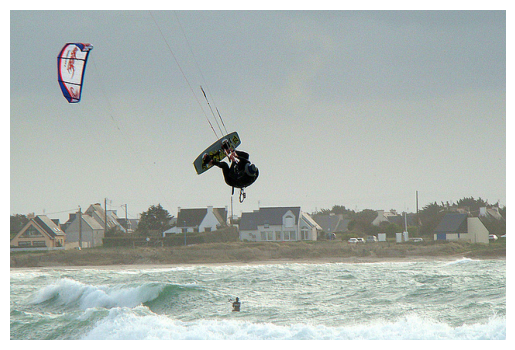

car


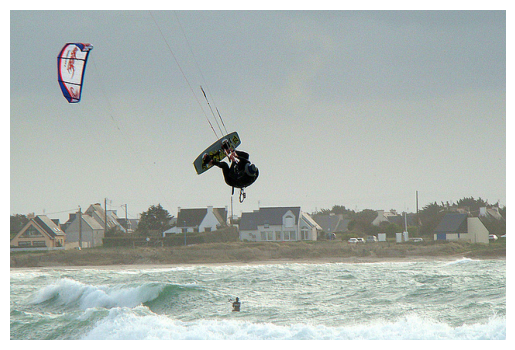

chair


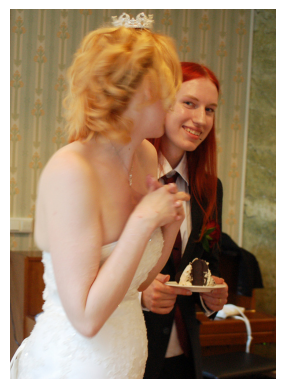

book


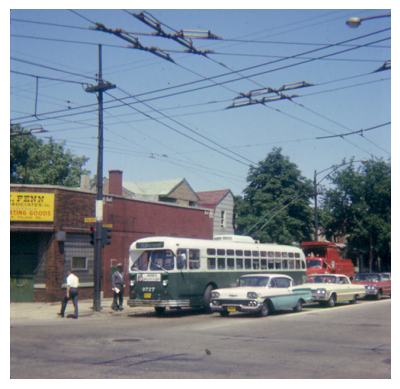

bottle


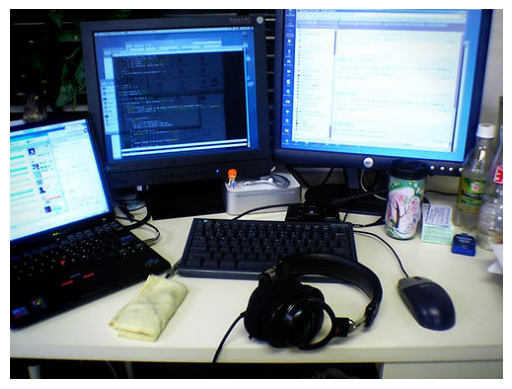

In [58]:
import matplotlib.image as mpimg

cats =  [categories[cat_id] for cat_id in top_5_category_ids]

base_dir = path1

for cat in cats:
    cat_ids = coco.getCatIds(catNms=[cat])
    ann_ids = coco.getAnnIds(catIds=cat_ids)

    img_ids = coco.getImgIds(catIds=cat_ids)

    # Load metadata for the images
    images = coco.loadImgs(img_ids)

    img_metadata = images[0]
    # Load the image
    img_path = f"{base_dir}\\{img_metadata['file_name']}"
    print(cat)
    img = mpimg.imread(img_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off the axes
    plt.show()

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

cats = [categories[cat_id] for cat_id in top_5_category_ids]
base_dir = path1

for cat in cats:
    # Get category IDs and associated annotations
    cat_ids = coco.getCatIds(catNms=[cat])
    ann_ids = coco.getAnnIds(catIds=cat_ids)
    
    # Get image IDs for the category
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    # Load metadata for the images
    images = coco.loadImgs(img_ids)
    
    img_metadata = images[0]  # Load first image metadata for the category
    img_path = f"{base_dir}\\{img_metadata['file_name']}"
    print(f"Displaying image for category: {cat}")
    
    # Load the image
    img = mpimg.imread(img_path)
    
    # Load annotations for the selected image
    anns = coco.loadAnns(ann_ids)
    
    # Create a blank mask (same size as the image, filled with zeros)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    # Loop through each annotation and add it to the mask
    for ann in anns:
        # Mask is encoded in RLE (Run Length Encoding), decode it to a binary mask
        rle_mask = coco.annToMask(ann)
        mask = np.maximum(mask, rle_mask)  # Combine with the current mask
    
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image
    axes[0].imshow(img)
    axes[0].axis('off')  # Turn off the axes
    axes[0].set_title(f"Image: {img_metadata['file_name']}")
    
    # Display the mask
    axes[1].imshow(mask, cmap='gray')  # Show the mask in grayscale
    axes[1].axis('off')  # Turn off the axes
    axes[1].set_title(f"Mask for {cat}")
    
    # Show the plot
    plt.show()


Displaying image for category: person


ValueError: operands could not be broadcast together with shapes (426,640) (640,480) 

In [72]:
cat = cats[0]
print(cat)
cat_ids = coco.getCatIds(catNms=[cat])
print(cat_ids)
ann_ids = coco.getAnnIds(catIds=cat_ids)
print(len(ann_ids))
anns = coco.loadAnns(ann_ids[0])
print(anns)

person
[1]
11004
[{'segmentation': [[125.12, 539.69, 140.94, 522.43, 100.67, 496.54, 84.85, 469.21, 73.35, 450.52, 104.99, 342.65, 168.27, 290.88, 179.78, 288.0, 189.84, 286.56, 191.28, 260.67, 202.79, 240.54, 221.48, 237.66, 248.81, 243.42, 257.44, 256.36, 253.12, 262.11, 253.12, 275.06, 299.15, 233.35, 329.35, 207.46, 355.24, 206.02, 363.87, 206.02, 365.3, 210.34, 373.93, 221.84, 363.87, 226.16, 363.87, 237.66, 350.92, 237.66, 332.22, 234.79, 314.97, 249.17, 271.82, 313.89, 253.12, 326.83, 227.24, 352.72, 214.29, 357.03, 212.85, 372.85, 208.54, 395.87, 228.67, 414.56, 245.93, 421.75, 266.07, 424.63, 276.13, 437.57, 266.07, 450.52, 284.76, 464.9, 286.2, 479.28, 291.96, 489.35, 310.65, 512.36, 284.76, 549.75, 244.49, 522.43, 215.73, 546.88, 199.91, 558.38, 204.22, 565.57, 189.84, 568.45, 184.09, 575.64, 172.58, 578.52, 145.26, 567.01, 117.93, 551.19, 133.75, 532.49]], 'area': 47803.279549999985, 'iscrowd': 0, 'image_id': 425226, 'bbox': [73.35, 206.02, 300.58, 372.5], 'category_id': 1,

Displaying image for category: person


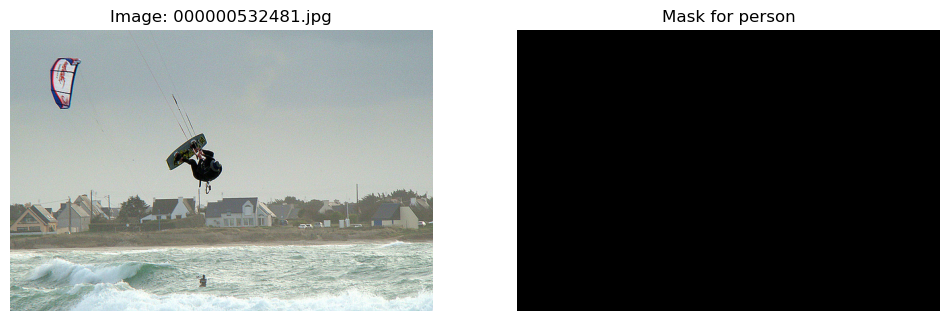

Displaying image for category: car


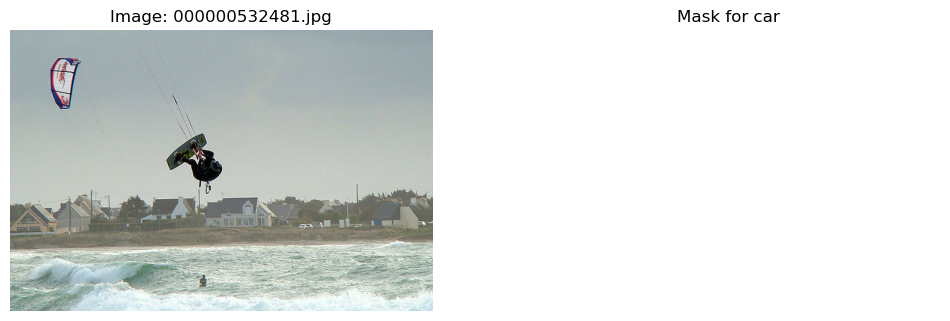

Displaying image for category: chair


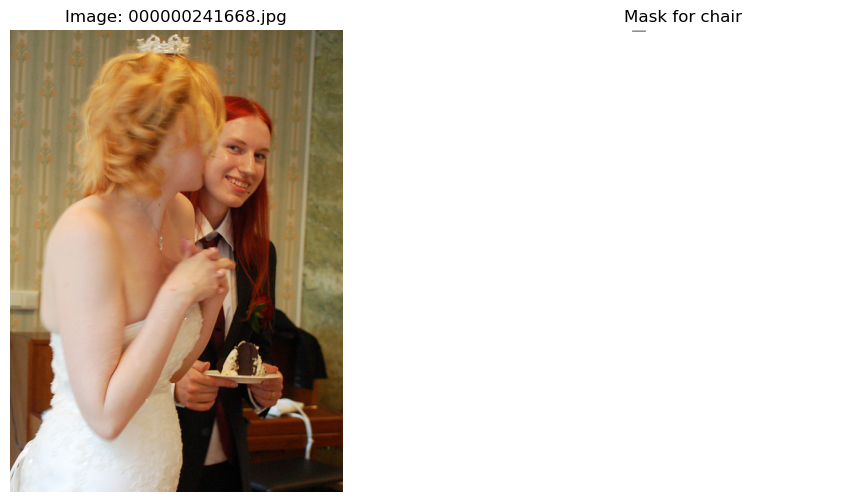

Displaying image for category: book


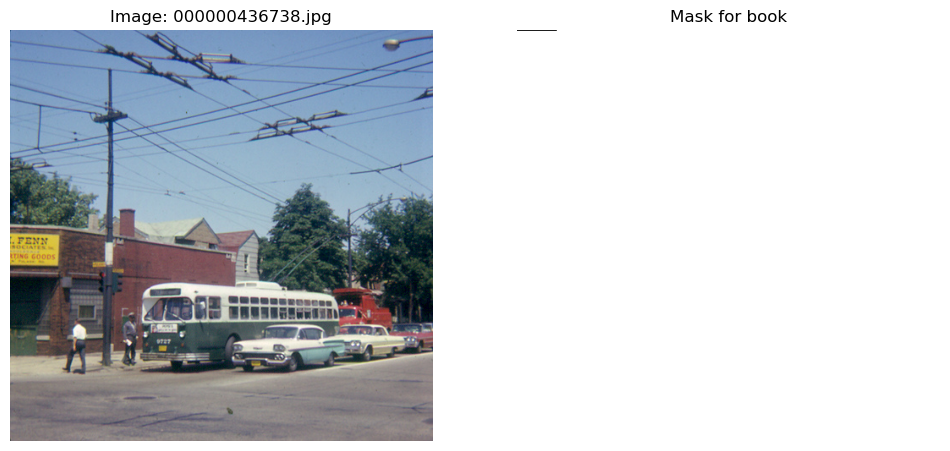

Displaying image for category: bottle


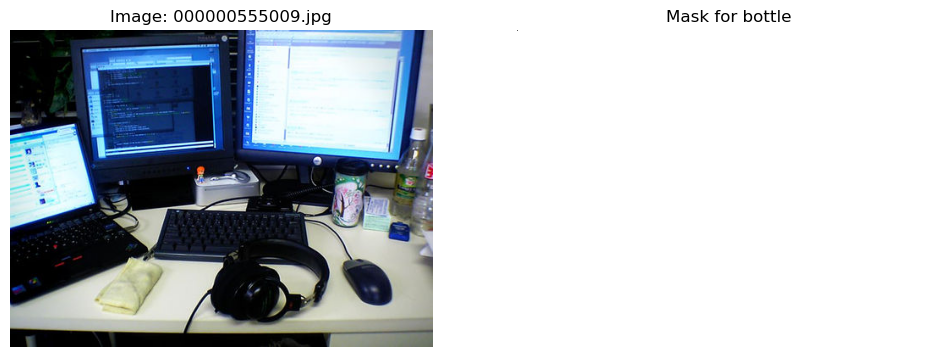

In [62]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

cats = [categories[cat_id] for cat_id in top_5_category_ids]
base_dir = path1

for cat in cats:
    # Get category IDs and associated annotations
    cat_ids = coco.getCatIds(catNms=[cat])
    ann_ids = coco.getAnnIds(catIds=cat_ids)
    
    # Get image IDs for the category
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    # Load metadata for the images
    images = coco.loadImgs(img_ids)
    
    img_metadata = images[0]  # Load first image metadata for the category
    img_path = f"{base_dir}\\{img_metadata['file_name']}"
    print(f"Displaying image for category: {cat}")
    
    # Load the image
    img = mpimg.imread(img_path)
    
    # Load annotations for the selected image
    anns = coco.loadAnns(ann_ids)
    
    # Create a blank mask (same size as the image, filled with zeros)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    # Loop through each annotation and add it to the mask
    for ann in anns:
        # Mask is encoded in RLE (Run Length Encoding), decode it to a binary mask
        rle_mask = coco.annToMask(ann)
        
        # Ensure the mask and rle_mask have the same dimensions
        if rle_mask.shape != mask.shape:
            rle_mask_resized = np.resize(rle_mask, mask.shape)  # Resize RLE mask to match image size
        else:
            rle_mask_resized = rle_mask
        
        mask = np.maximum(mask, rle_mask_resized)  # Combine with the current mask
    
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image
    axes[0].imshow(img)
    axes[0].axis('off')  # Turn off the axes
    axes[0].set_title(f"Image: {img_metadata['file_name']}")
    
    # Display the mask
    axes[1].imshow(mask, cmap='gray')  # Show the mask in grayscale
    axes[1].axis('off')  # Turn off the axes
    axes[1].set_title(f"Mask for {cat}")
    
    # Show the plot
    plt.show()


In [86]:
# Paths to COCO dataset
instances_val = r"..\datasets\coco"

COCO_PATH = instances_val
TRAIN_IMAGES_PATH = os.path.join(COCO_PATH, 'images', 'val2017')
ANNOTATIONS_PATH = os.path.join(COCO_PATH, 'annotations', 'instances_val2017.json')
OUTPUT_FILES =  os.path.join(COCO_PATH, 'preprocessed', 'val2017')   

OUTPUT_PATH = os.path.abspath(OUTPUT_FILES)

In [88]:
absolute_path = os.path.abspath(ANNOTATIONS_PATH)

print(OUTPUT_PATH)

c:\Users\ruben\Desktop\code_tfm\datasets\coco\preprocessed\val2017


Generación del dataset final:
Iteración en cuanto a los classId seleccionados, guardando primero imprimiendo las máscaras

loading annotations into memory...
Done (t=1.49s)
creating index...
index created!
Id cathegory 1
Im path ..\datasets\coco\images\val2017\000000532481.jpg


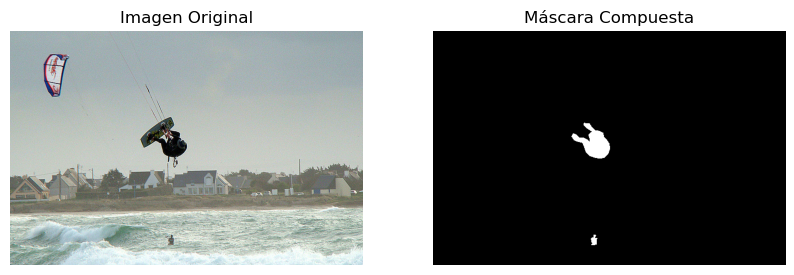

Im path ..\datasets\coco\images\val2017\000000458755.jpg


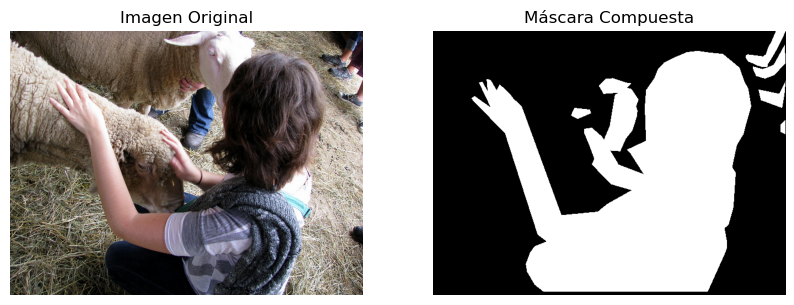

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Id cathegory 3
Im path ..\datasets\coco\images\val2017\000000532481.jpg


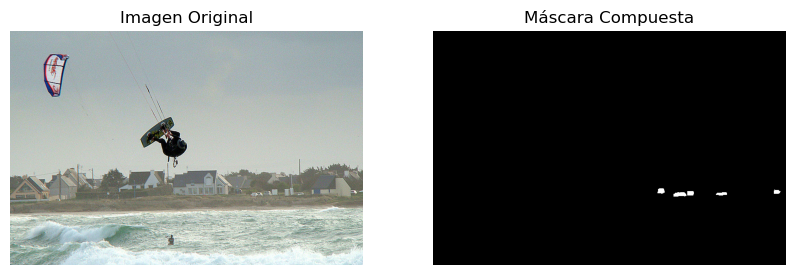

Im path ..\datasets\coco\images\val2017\000000184324.jpg


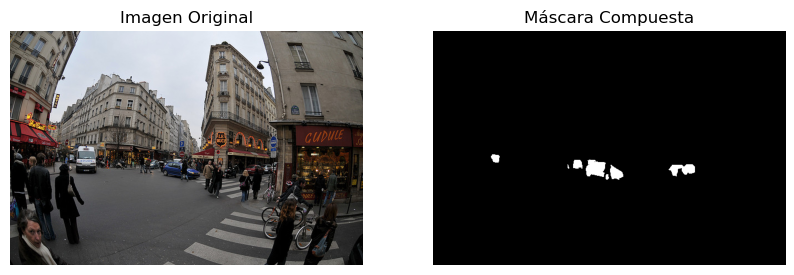

loading annotations into memory...
Done (t=1.52s)
creating index...
index created!
Id cathegory 62
Im path ..\datasets\coco\images\val2017\000000241668.jpg


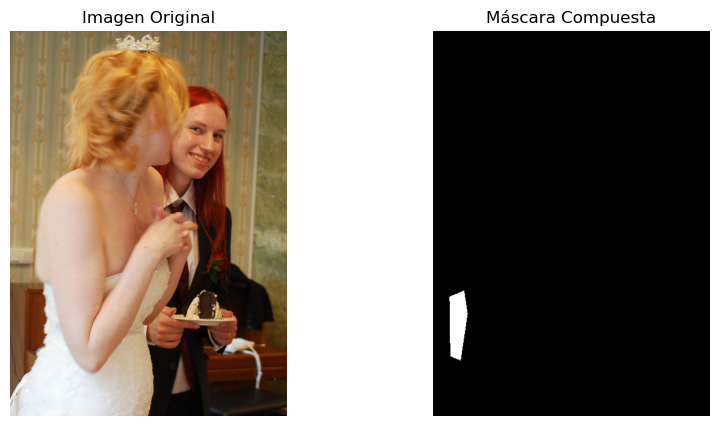

Im path ..\datasets\coco\images\val2017\000000311303.jpg


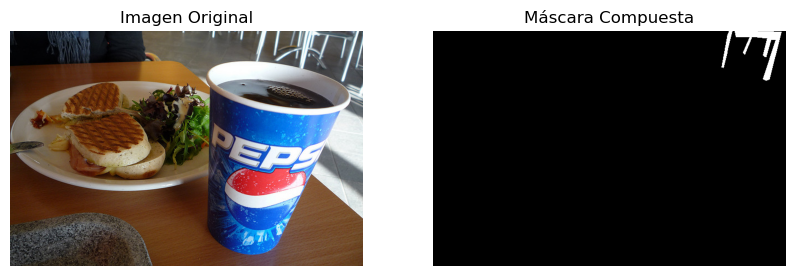

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
Id cathegory 84
Im path ..\datasets\coco\images\val2017\000000436738.jpg


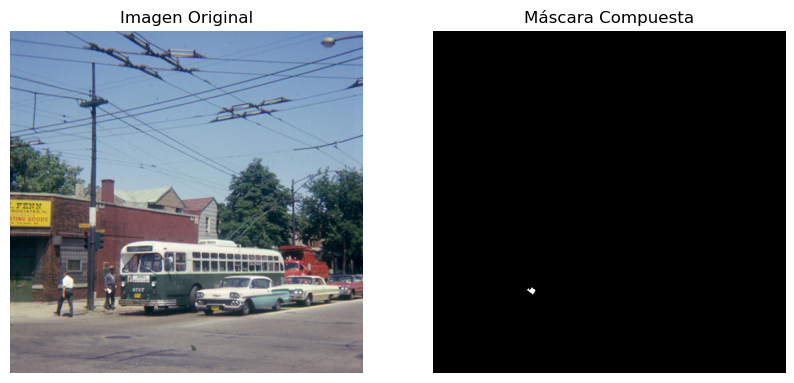

Im path ..\datasets\coco\images\val2017\000000025603.jpg


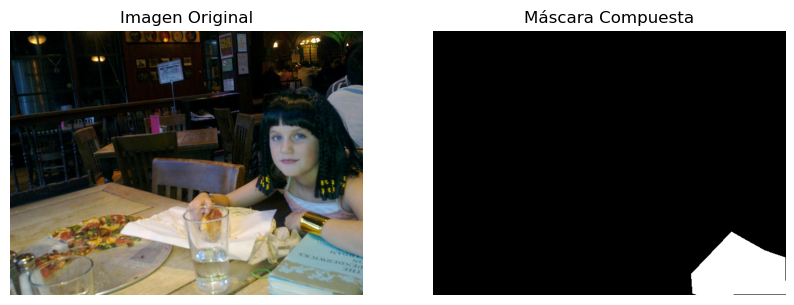

loading annotations into memory...
Done (t=1.54s)
creating index...
index created!
Id cathegory 44
Im path ..\datasets\coco\images\val2017\000000555009.jpg


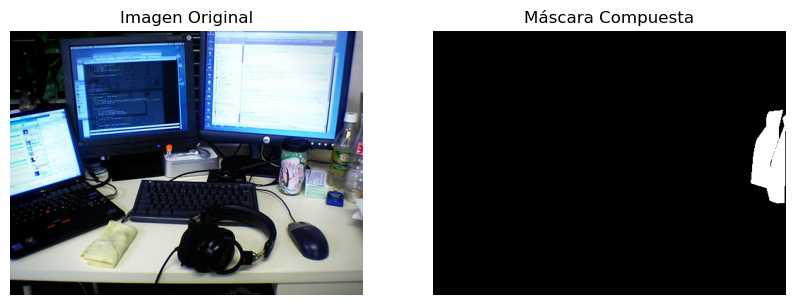

Im path ..\datasets\coco\images\val2017\000000385029.jpg


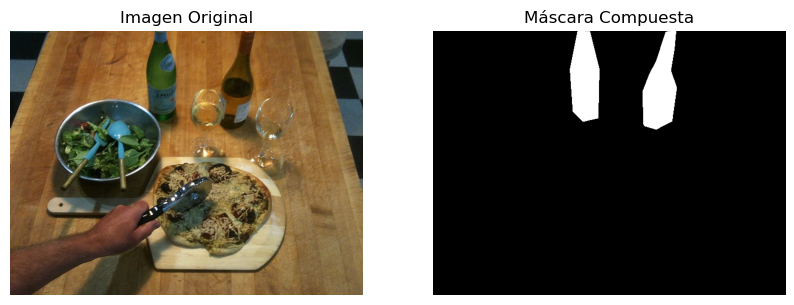

In [99]:
# Configuración inicial



def generate_composite_mask( class_id, output_file):
    # Carga el archivo de anotaciones COCO
    coco = COCO(absolute_path)

    # Obtén todas las imágenes que contienen el class_id especificado

    print("Id cathegory",class_id)
    cat_ids = [class_id]
    img_ids = coco.getImgIds(catIds=cat_ids)
    images = coco.loadImgs(img_ids)

    # Crear una imagen vacía para superponer las máscaras
    

    for img in images[:2]:
        img_path = os.path.join(TRAIN_IMAGES_PATH, img['file_name'])
        composite_mask = None
        # Cargar la información de la imagen
        img_id = img['id']
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id], catIds=cat_ids, iscrowd=False))


        # Generar y superponer máscaras
        for ann in annotations:

            # Leer la imagen
            height, width = img['height'], img['width']
            if composite_mask is None:
                composite_mask = np.zeros((height, width), dtype=np.uint8)            
            mask = coco.annToMask(ann)
            composite_mask = np.maximum(composite_mask, mask * 255)

        # Guardar la máscara compuesta como imagen
        #cv2.imwrite(output_file, composite_mask)

        # Mostrar la máscara compuesta
        # Mostrar la imagen original


       

        # Leer la imagen original
        print("Im path", img_path)
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(original_image)
        axs[0].axis('off')
        axs[0].set_title('Imagen Original')
        
        # Mostrar la máscara compuesta
        axs[1].imshow(composite_mask, cmap='gray')
        axs[1].axis('off')
        axs[1].set_title('Máscara Compuesta')

        plt.show()





coco_annotation_file = 'path/to/annotations/instances_val2017.json'  # Cambia a la ruta correcta
class_id = 1  # Cambia al class_id deseado
output_file = 'composite_mask.png'
for i in top_5_category_ids:
    generate_composite_mask( i, OUTPUT_PATH)

Displaying image for category: 1


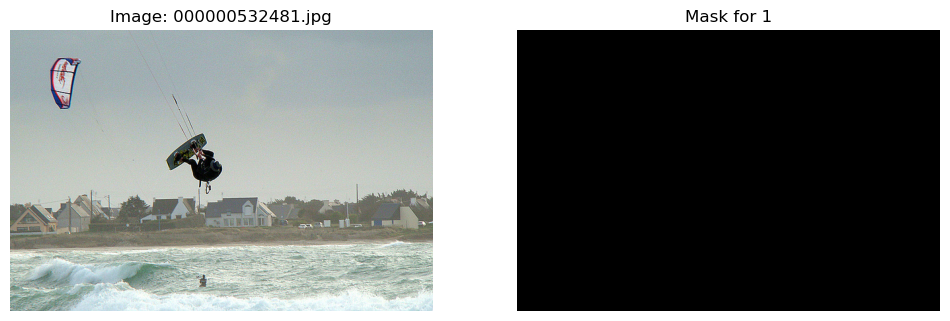

Displaying image for category: 3


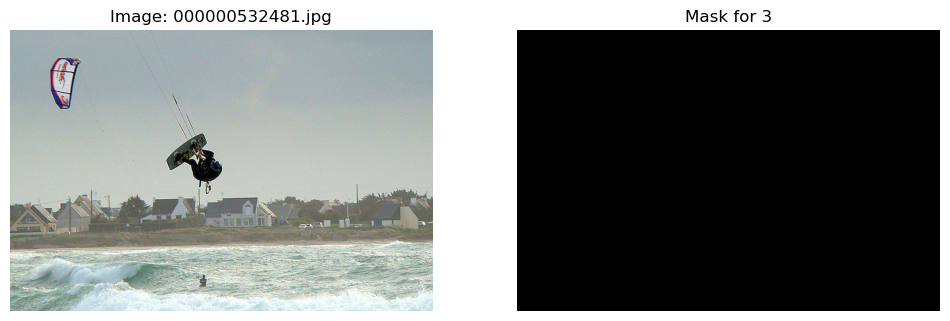

Displaying image for category: 62


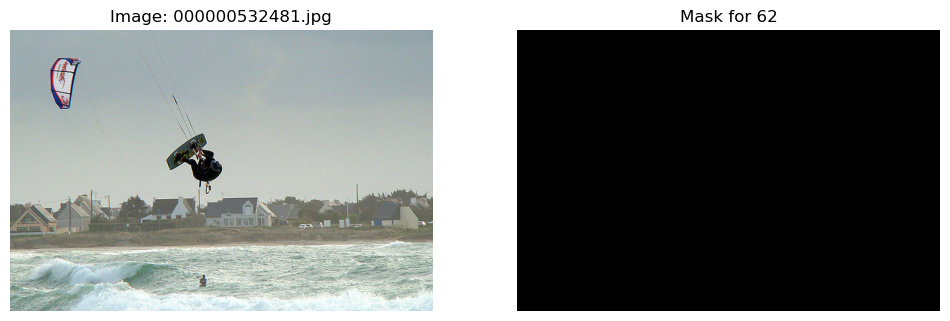

Displaying image for category: 84


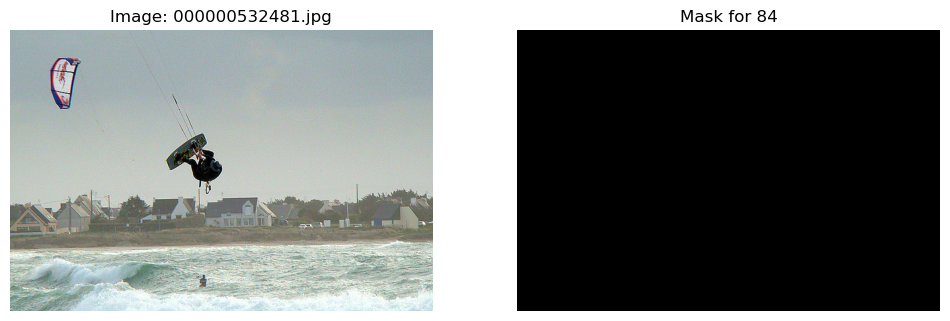

Displaying image for category: 44


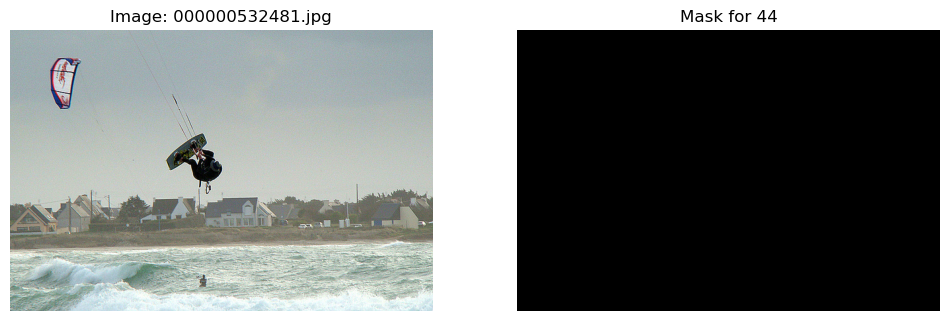

In [97]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

base_dir = path1

for cat in top_5_category_ids:
    # Get category IDs and associated annotations
    ann_ids = coco.getAnnIds(catIds=cat_ids)
    
    # Get image IDs for the category
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    # Load metadata for the images
    images = coco.loadImgs(img_ids)
    
    img_metadata = images[0]  # Load first image metadata for the category
    img_path = f"{base_dir}\\{img_metadata['file_name']}"
    print(f"Displaying image for category: {cat}")
    
    # Load the image
    img = mpimg.imread(img_path)
    
    # Load annotations for the selected image
    anns = coco.loadAnns(ann_ids)
    
    # Create a blank mask (same size as the image, filled with zeros)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    # Loop through each annotation and add it to the mask
    for ann in anns:
        # Mask is encoded in RLE (Run Length Encoding), decode it to a binary mask
        rle_mask = coco.annToMask(ann)
        
        # Ensure the mask and rle_mask have the same dimensions
        if rle_mask.shape != mask.shape:
            rle_mask_resized = np.resize(rle_mask, mask.shape)  # Resize RLE mask to match image size
        else:
            rle_mask_resized = rle_mask
        
        mask = np.maximum(mask, rle_mask_resized)  # Combine with the current mask
    
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the image
    axes[0].imshow(img)
    axes[0].axis('off')  # Turn off the axes
    axes[0].set_title(f"Image: {img_metadata['file_name']}")
    
    # Display the mask
    axes[1].imshow(mask, cmap='gray')  # Show the mask in grayscale
    axes[1].axis('off')  # Turn off the axes
    axes[1].set_title(f"Mask for {cat}")
    
    # Show the plot
    plt.show()


In [42]:
# Step 2: Create Masks
for img_info in coco.loadImgs(coco.getImgIds()):
    # Get all annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=top_5_category_ids)
    anns = coco.loadAnns(ann_ids)
    
    # Skip images without the top 5 classes
    if not anns:
        continue

    # Create an empty mask
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Add annotations to the mask
    for ann in anns:
        category_id = ann['category_id']
        class_index = top_5_category_ids.index(category_id) + 1  # Class IDs start from 1
        rle = coco.annToRLE(ann)
        ann_mask = mask_utils.decode(rle)
        mask[ann_mask == 1] = class_index  # Assign class index to the mask

    # Save the mask
    mask_filename = os.path.join(result2, f"{img_info['file_name'].split('.')[0]}_mask.png")
    cv2.imwrite(mask_filename, mask)

print(f"Masks saved to {result2}")

Masks saved to C:\Users\ruben\Desktop\code_tfm\datasets\coco\masks


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Paths
image_dir = "path/to/images"  # Directory containing original images
mask_dir = "path/to/masks"    # Directory containing masks
img_size = (128, 128)         # Resize images and masks to this size
num_classes = 5               # Number of classes (top 5 classes)

# Step 1: Load and Preprocess the Dataset
def load_data(image_dir, mask_dir, img_size):
    images = []
    masks = []

    for img_file in os.listdir(image_dir)[:1000]:
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img)

        # Load mask
        mask_path = os.path.join(mask_dir, img_file.replace('.jpg', '_mask.png'))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
        masks.append(mask)

    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension
    return images, masks

images, masks = load_data(image_dir, mask_dir, img_size)





In [ ]:
# One-hot encode masks
masks = tf.keras.utils.to_categorical(masks, num_classes=num_classes + 1)  # +1 for background class

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Step 2: Define the U-Net Model
def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs, outputs)
    return model

input_shape = (img_size[0], img_size[1], 3)
model = unet_model(input_shape, num_classes + 1)




In [ ]:
# Step 3: Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20
)

# Save the model
model.save("unet_segmentation_model.h5")

print("Training complete and model saved.")